# Bitcoin's transactions analysis


The goal of this report is to show the results from the analysis of licit and illicit transactions from the Elliptic Dataset using Machine Learning models. We can download it from Kaggle in [this link](https://www.kaggle.com/ellipticco/elliptic-data-set). It has 203,769 transactions, but the labeled part is only twenty-three percent of the examples. Below has brief description from the Kaggle site.

> The Elliptic Data Set maps Bitcoin transactions to real entities belonging to licit categories (exchanges, wallet providers, miners, licit services, etc.) versus illicit ones (scams, malware, terrorist organizations, ransomware, Ponzi schemes, etc.). The task on the dataset is to classify the illicit and licit nodes in the graph.

The dataset used in this report concerns the labeled parcel extracted from the Elliptic Dataset, this parcel has 46,564 examples. The dataset can be downloaded by [clicking here](https://drive.google.com/uc?id=1N58mGegfUs9hH3f0jVVxh1Gqjnlugf04).

[1] Elliptic, www.elliptic.co.

[2] M. Weber, G. Domeniconi, J. Chen, D. K. I. Weidele, C. Bellei, T. Robinson, C. E. Leiserson, "Anti-Money Laundering in Bitcoin: Experimenting with Graph Convolutional Networks for Financial Forensics", KDD ’19 Workshop on Anomaly Detection in Finance, August 2019, Anchorage, AK, USA.




## Utility functions to acquire the dataset
This section presents the functions used to acquire the dataset from Google Drive. Each function contains your own documentation and can be checked below.

In [27]:
import os

import pandas as pd
import gdown
import zipfile

def download_file_from_gdrive(url, filename, dir):
    """Downloads public zip files from Google Drive and extracts
    its contents to a given directory.

    Parameters:
    -----------
    url : string
        Google Drive url for the shared file.

    filename : string
        Output filename for the file.
    
    dir : string
        Output directory where the file will be written.
    """

    gdown.download(url, filename, quiet=False)

    os.makedirs(dir, exist_ok=True)
    with zipfile.ZipFile(filename) as f:
        f.extractall(dir)

    os.remove(filename)

def load_elliptic_dataset(base_dir = 'datasets'):
    """Loads the elliptic dataset into Pandas dataframe.

    Parameters:
    -----------
    base_dir : string
        Directory path where the dataset will be extracted.abort

    Returns:
    --------
    tuple of Pandas dataframes
        The first dataframe contains the features and the second
        dataframe contains the classes.

    """
    features_path = os.path.join(base_dir, 'elliptic/features.csv')
    classes_path = os.path.join(base_dir, 'elliptic/classes.csv')

    txs_features = pd.read_csv(features_path)
    txs_classes = pd.read_csv(classes_path)

    X = txs_features
    y = txs_classes.where(txs_classes['class'] == 1, other=0)

    return X, y

## Loading dataset
The dataset will be download from Google Drive and stored inside the './datasets/elliptic/' folder. After this, the CSV files will be read and converted to Pandas dataframes.

In [28]:
url = 'https://drive.google.com/uc?id=1N58mGegfUs9hH3f0jVVxh1Gqjnlugf04'
filename = 'elliptic_dataset_filtered.zip'
dir = 'datasets'

# Download dataset
download_file_from_gdrive(url, filename, dir)

# Loading dataset
X, y = load_elliptic_dataset()

print('')
print('Features shape:', X.shape)
print('Classes distribution:')
y.value_counts()


Downloading...
From: https://drive.google.com/uc?id=1N58mGegfUs9hH3f0jVVxh1Gqjnlugf04
To: /home/hewerton/projects/CDadosSeg/final_assignment/02_experiments/elliptic_dataset_filtered.zip
33.3MB [00:01, 22.5MB/s]



Features shape: (46564, 165)
Classes distribution:


class
0        42019
1         4545
dtype: int64

As we can see, the dataset has 46,564 labeled examples. The illicit class represented by the value 1 is almost 10% of the examples, the remaining examples are licit transactions represented by the value 0. This situation shows us an unbalanced scenario that can result in an overfitted model.

## Prepocessing the dataset
To deal with this unbalanced dataset, we will apply a technique to undersampling the majority class until it reaches the same amount of examples the minority class has. In the code below is the function that we will use to undersampling the licit class.

In [29]:
def filter_majority_class(df):
    """Filters the dataset removing samples of the majority class
    to obtain a balanced dataset.false_values.

    Parameters:
    -----------
    df : dataframe
        Desbanlanced dataframe.

    Returns:
    --------
    dataframe
        a balanced dataframe.

    """

    minority_class_df = df[df['class'] == 1]
    majority_class_df = df[df['class'] == 0]

    majority_sample_df = majority_class_df.sample(minority_class_df.shape[0])
    
    return minority_class_df.append(majority_sample_df)

In [30]:

# producing a copy of the orignal datasets
full_dataset = X.copy()
full_dataset['class'] = y.copy()

# appling a filter to balance the dataset on each
# timestamp grou
full_dataset_balanced = full_dataset.groupby("1").apply(filter_majority_class)

# Shows the quantity of each class in the dataset
full_dataset_balanced['class'].value_counts()

0    4545
1    4545
Name: class, dtype: int64

After appling the filter we have a new dataset with the same number of examples for each class, as we can see above. However, the total number of examples decline to 9,090. This new dataset will be used to train and test machine learning model for evaluation.

## Normalizing the dataset
Let's take a look at how our data looks like and see if they need a transformation.

In [31]:
X.describe()

,1,2,3,4,5,6,7,8,9,10,...,156,157,158,159,160,161,162,163,164,165
count,46564.000000,46564.000000,46564.000000,46564.000000,46564.000000,46564.000000,46564.000000,46564.000000,46564.000000,46564.000000,...,46564.000000,46564.000000,46564.000000,46564.000000,46564.000000,46564.000000,46564.000000,46564.000000,46564.000000,46564.000000
mean,24.599046,-0.052645,0.159103,0.148974,0.172216,0.028651,0.184429,-0.015381,-0.077488,-0.059497,...,-0.012148,-0.054622,-0.021395,0.088977,0.088828,-0.010401,0.057301,0.076348,0.045520,-0.037397
std,15.158091,0.702554,1.544040,1.063158,1.600931,1.729706,1.589399,0.577378,0.588778,0.667889,...,0.979383,0.916098,0.956718,0.978313,0.979057,0.511929,1.729502,1.764513,1.065455,0.998764
min,1.000000,-0.172982,-0.210553,-1.756361,-0.121970,-0.063725,-0.113002,-0.061584,-0.163646,-0.169460,...,-0.624045,-0.577099,-0.626229,-0.979074,-0.978556,-0.216057,-0.125939,-0.131155,-0.269818,-1.760926
25%,10.000000,-0.172683,-0.162140,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.163614,-0.169230,...,-0.599493,-0.569626,-0.588384,-0.979074,-0.978556,-0.098889,-0.087490,-0.131155,-0.140597,-0.120613
50%,24.000000,-0.170652,-0.113851,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.163383,-0.167581,...,-0.470592,-0.487424,-0.443313,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613
75%,39.000000,-0.141446,0.016948,1.018602,0.028105,-0.043875,-0.029140,-0.061584,-0.158465,-0.145476,...,-0.004094,0.131350,0.105434,1.461330,1.461369,0.018279,-0.068266,-0.084674,-0.083166,0.139080
max,49.000000,39.786756,73.595052,2.683580,49.027598,260.090707,54.565178,44.365651,40.721063,40.142250,...,5.397464,4.474613,7.888811,1.461330,1.461369,58.485180,251.849028,238.783493,86.778382,1.519700


Due to the high variance, we will use a standard scaler to normalize the data.

In [32]:
from sklearn.preprocessing import StandardScaler


# Separates the features and classes from the full dataset, then
# get the values as numpy arrays
features = full_dataset_balanced.iloc[:,:-1].values
classes = full_dataset_balanced.iloc[:,-1].values


# Normalizes the features with standard scaler
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)



In [33]:
new_df = pd.DataFrame(normalized_features)
new_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,164
count,9.090000e+03,9.090000e+03,9.090000e+03,9.090000e+03,9.090000e+03,9.090000e+03,9.090000e+03,9.090000e+03,9.090000e+03,9.090000e+03,...,9.090000e+03,9.090000e+03,9.090000e+03,9.090000e+03,9.090000e+03,9.090000e+03,9.090000e+03,9090.000000,9.090000e+03,9.090000e+03
mean,-1.500816e-16,1.172513e-17,-6.253401e-18,1.250680e-17,1.563350e-17,4.690051e-18,3.126701e-18,-7.504082e-17,-3.634790e-17,2.032355e-17,...,-1.250680e-17,1.876020e-17,1.250680e-17,-6.097066e-17,4.064711e-17,4.533716e-17,-1.250680e-17,0.000000,-6.253401e-18,-1.563350e-17
std,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,...,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00,1.000055,1.000055e+00,1.000055e+00
min,-2.120302e+00,-1.392413e-01,-1.624907e-01,-1.911404e+00,-1.449142e-01,-8.485220e-02,-1.415172e-01,-8.009835e-02,-1.643991e-01,-1.377214e-01,...,-5.876715e-01,-4.465387e-01,-6.465579e-01,-1.232173e+00,-1.230601e+00,-9.350526e-01,-1.022690e-01,-0.084841,-2.727856e-01,-1.968534e+00
25%,-8.875050e-01,-1.387659e-01,-1.276811e-01,-1.369394e+00,-1.449142e-01,-8.485220e-02,-1.415172e-01,-8.009835e-02,-1.641707e-01,-1.372688e-01,...,-5.420713e-01,-4.465387e-01,-5.882917e-01,-1.232173e+00,-1.230601e+00,-3.649139e-01,-6.884906e-02,-0.084841,-1.203732e-01,-3.675661e-02
50%,-6.936055e-03,-1.369171e-01,-1.089813e-01,2.566347e-01,-1.449142e-01,-5.293255e-02,-1.415172e-01,-8.009835e-02,-1.627904e-01,-1.354392e-01,...,-4.052707e-01,-4.270641e-01,-4.022040e-01,2.293817e-01,2.313724e-01,2.052249e-01,-6.884906e-02,-0.084841,-6.956913e-02,-3.675661e-02
75%,6.975191e-01,-1.152625e-01,-5.806176e-02,7.986443e-01,-8.800529e-02,-5.293255e-02,-8.187647e-02,-8.009835e-02,-1.510626e-01,-1.157610e-01,...,5.073126e-02,-1.057331e-01,1.327527e-01,2.293817e-01,2.313724e-01,2.052249e-01,-6.884906e-02,-0.050610,-6.956913e-02,-3.675661e-02
max,2.106429e+00,5.606322e+01,4.946363e+01,2.424673e+00,2.825261e+01,6.375445e+01,2.961922e+01,5.334659e+01,2.703648e+01,6.172676e+01,...,6.723560e+00,6.126140e+00,8.909100e+00,1.690937e+00,1.693346e+00,5.322813e+01,7.788309e+01,79.738306,5.928233e+01,1.895021e+00


The results above show us the description of the new dataset after normalization. This process is necessary when the data has a high variance between your values. If we use the raw values, we can get an undesirable model that makes a lot of wrong predictions.

## Spliting the dataset
For this experiment we will use 80% of the dataset for training and test. The remaining 20% will be used to validate the models generating comparabel results. 


In [34]:
from sklearn.model_selection import train_test_split

# X_train and y_train represents 80% of the dataset and 
# will be used for training the model, the remaining 20%
# will be used for model validation
X_train, X_test, y_train, y_test = train_test_split(
                normalized_features, classes, test_size=0.2, random_state=42)

print("Train dataset shapes - 80% from original dataset")
print(f"X: {X_train.shape}")
print(f"y: {y_train.shape}")
print()
print("Test dataset shapes - 20% from original dataset")
print(f"X: {X_test.shape}")
print(f"y: {y_test.shape}")

Train dataset shapes - 80% from original dataset
X: (7272, 165)
y: (7272,)

Test dataset shapes - 20% from original dataset
X: (1818, 165)
y: (1818,)


We will use 7,272 examples for training and 1,818 examples for validation.

## Utility functions for evaluation
This section presents the functions used to evaluate the models and plot results. Each function contains your own documentation and can be checked below.

In [35]:
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection

def evaluate_model(classifier, X_test, y_test):
    """Evaluates a model getting the principal metrics.

    Parameters:
    -----------
    classifier : scikit-learn model instance
        Trained model instance.
    
    X_test : array-like of shape (n_queries, n_features)
        Test samples.
    
    y_test : array-like of shape (n_samples,)
        Target values.

    Returns:
    --------
    result : dict
        Principal evaluation metrics.

    """

    # predicting for test dataset
    y_pred = classifier.predict(X_test)

    # getting the metrics
    result = {}
    result['acc'] = metrics.accuracy_score(y_test, y_pred)
    result['r_score'] = metrics.recall_score(y_test, y_pred)
    result['loss'] = metrics.log_loss(y_test, y_pred)
    result['y_pred'] = y_pred
    result['y_true'] = y_test

    return result


def kfold_cross_validation(classifier, X, y, n_splits=5):
    """Evaluates a model with a k-fold cross-validation
    approach getting the principal metrics.

    Parameters:
    -----------
    classifier : scikit-learn model instance
        Trained model instance.
    
    X_test : array-like of shape (n_queries, n_features)
        Test samples
    
    y_test : array-like of shape (n_samples,)
        Target values.

    n_splits : int, default=5
        Number of folds.


    Returns:
    --------
    result : list of dicts
        A list of dicts with the principal evaluation metrics
        for each fold.

    """


    results = []

    # creates a fold generator
    cv = model_selection.StratifiedKFold(n_splits, 
                                         shuffle=True, 
                                         random_state=42)

    # for each fold, fit the model and predict with test dataset
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        classifier.fit(X[train], y[train])
        y_pred = classifier.predict(X[test])
        y_score = classifier.predict_proba(X[test])
        y_true = y[test]


        # collecting the results
        result = {}
        result['acc'] = metrics.accuracy_score(y_true, y_pred)
        result['r_score'] = metrics.recall_score(y_true, y_pred)
        result['loss'] = metrics.log_loss(y_true, y_pred)
        result['y_score'] = y_score
        result['y_pred'] = y_pred
        result['y_true'] = y_true
        results.append(result)

    return results

def plot_kfold_roc(title, results):
    """Plots the ROC curves given the results of a k-fold 
    cross-validation.

    Parameters:
    -----------
    title : str
        Plot title

    results : list of dicts
        A list of dicts with the principal evaluation metrics
        for each fold.
    """

    # creating a figure to draw the curves
    roc_curves_fig = plt.figure()
    ax = roc_curves_fig.add_subplot()
    ax.set_title('{} ROC for K={}'.format(title, len(results)),
                 fontsize=16)

    for i, result in enumerate(results):
        fpr, tpr, _ = metrics.roc_curve(result['y_true'],
                                        result['y_score'][:,1])
        roc_auc = metrics.auc(fpr, tpr)

        viz = metrics.RocCurveDisplay(
            fpr=fpr,
            tpr=tpr,
            roc_auc=roc_auc)

        # plotting each curve in the figure
        viz.plot(ax=ax, name=f"Fold {i}")
    plt.tight_layout()

def plot_kfold_confusions_matrixes(title, results):
    """Plots the confusions matrixes of each fold from a k-fold 
    cross-validation.

    Parameters:
    -----------
    title : str
        Plot title

    results : list of dicts
        A list of dicts with the principal evaluation metrics
        for each fold.
    """


    # creating a figure to draw the confusion matrixes
    confusion_matrixes_fig = plt.figure(figsize=(7, 8))
    confusion_matrixes_fig.suptitle('Confusion Matrixes for each fold with {}'
                                    .format(title),
                                    fontsize=16,)

    for i, result in enumerate(results):
        cm = metrics.confusion_matrix(result['y_true'], result['y_pred'])
        
        ax = confusion_matrixes_fig.add_subplot(3, 2, i+1)
        ax.set_title('Fold {} - Recall: {:.3f} - Loss: {:.3f}'
                            .format(i, result['r_score'], result['loss']))

        viz = metrics.ConfusionMatrixDisplay(
            confusion_matrix=cm)
        viz.plot(ax=ax)
    plt.tight_layout()
        


def plot_confusion_matrix_fig(title, result):
    """Plots the confusion matrix.

    Parameters:
    -----------
    title : str
        Plot title

    results : dict
        A dict with the principal evaluation metrics.
    """


    fig = plt.figure()
    fig.suptitle(title, size=16)

    ax = fig.add_subplot()
    cm = metrics.confusion_matrix(result['y_true'], result['y_pred'])
        
    ax.set_title('Recall: {:.3f} - Loss: {:.3f}'
                        .format(result['r_score'], result['loss']))

    viz = metrics.ConfusionMatrixDisplay(
        confusion_matrix=cm)
    viz.plot(ax=ax)
    plt.suptitle(title)
    plt.tight_layout()

## Classification with KNN, Random Forest and Multi-layer Perceptron
For this experiment, we will use two instances of each model

- The first instance will be used for a simple evaluation.

- The second instance will be used for a k-fold cross-validation.

We will use the training dataset to train the models then we will use the trained model to predict the test dataset and getting the results.

#### Models configuration

- KNN
    - Number of neighbors: 5
- Random Forest
    - Number of estimators: 150
    - Criteria: Gini
- Multi-layer Perceptron
    - Hidden layers: 1
    - Maximum number of iterations: 1000
    - Layers: 1 layer with 100 perceptrons

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# KNN with the number of neightbors equals to five
knn = KNeighborsClassifier(n_neighbors=5)
knn_kfold = KNeighborsClassifier(n_neighbors=5)

# Random Forest with 150 estimators
random_forest = RandomForestClassifier(n_estimators=150, 
                                       random_state=42)
random_forest_kfold = RandomForestClassifier(n_estimators=150, 
                                             random_state=42)

# Multi-layer Perceptron with a maximum number of iterations of 1000 due to
# the high number of features.
mlp = MLPClassifier(random_state=42, max_iter=1000)
mlp_kfold = MLPClassifier(random_state=42, max_iter=1000)


### Simple evaluation with the split dataset
Let's train the models with the training part of the dataset and then plot a confusion matrix for each to see the metrics.

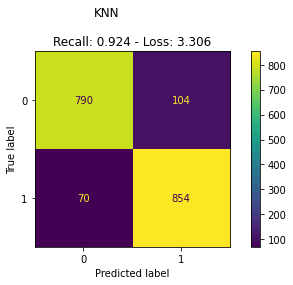

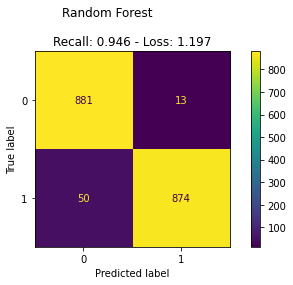

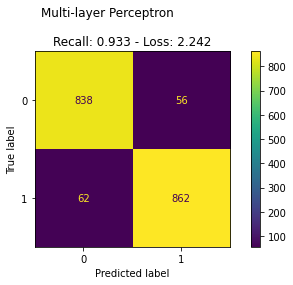

In [37]:


# Running KNN
knn.fit(X_train, y_train)
result = evaluate_model(knn, X_test, y_test)
plot_confusion_matrix_fig('KNN', result)

# Running Random Forest
random_forest.fit(X_train, y_train)
result = evaluate_model(random_forest, X_test, y_test)
plot_confusion_matrix_fig('Random Forest', result)

# Running MLP
mlp.fit(X_train, y_train)
result = evaluate_model(mlp, X_test, y_test)
plot_confusion_matrix_fig('Multi-layer Perceptron', result)


The results show us a recall of 0.927 for KNN, 0.950 for Random Forest, and 0.943 for MPL. The Random Forest and MPL obtained almost the same recall, but the MPL had a higher loss. Furthermore, only 62 examples from the test dataset were misclassified when the Random Forest classifier was used to predict it. The overall result demonstrates that we have a good model, but let's see if we can build a better one using k-fold cross-validation.

### K-fold cross-validation
To do k-fold cross-validation, we will use a helper class to split the dataset into k number of folds, then each fold will be used to train each model. Inside a fold has a random number of samples used as a test dataset to evaluate the model. After this, we will plot the ROC curves of each evaluation.

In [38]:


# Running KNN
knn_results = kfold_cross_validation(knn_kfold, X_train, y_train)

# Running Random Forest
random_forest_results = kfold_cross_validation(random_forest_kfold, 
                                               X_train, 
                                               y_train)

# Running MLP
mlp_results = kfold_cross_validation(mlp_kfold, X_train, y_train)




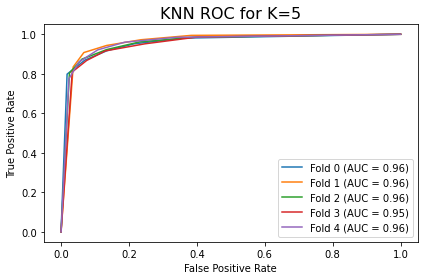

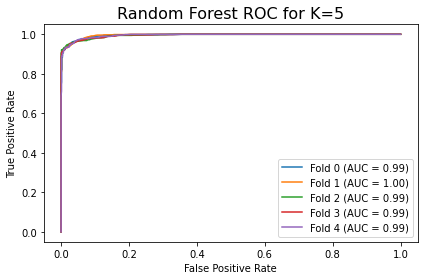

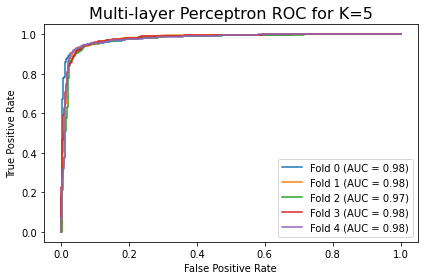

In [39]:

plot_kfold_roc('KNN', knn_results)
plot_kfold_roc('Random Forest', random_forest_results)
plot_kfold_roc('Multi-layer Perceptron', mlp_results)

The plots above show us that the Random Forest reached a high true-positive rate and low false-positive rate, making it suitable for a good model. In this scenario, the worst model was the KNN with an Area Under the Curve reaching 0.96 and a higher false-positive rate. The MLP model also can be used, but it has a higher computational power consumption, which makes Random Forest a better choice. Let's plot the confusion matrixes for each for comparison.

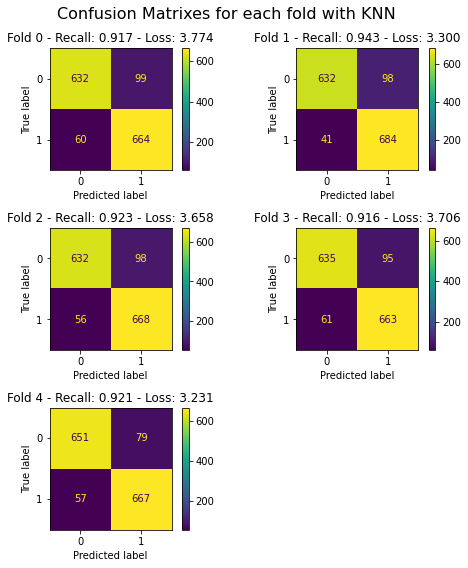

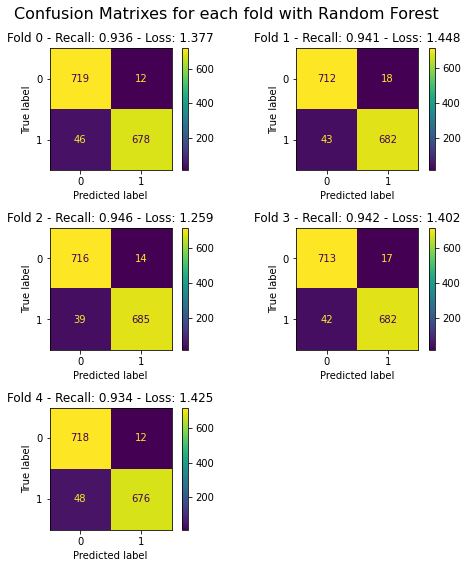

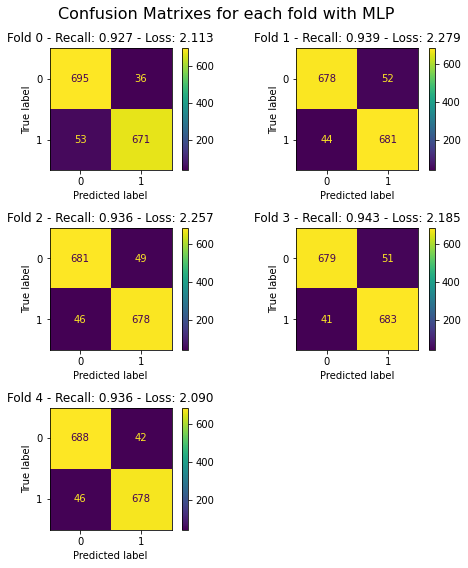

In [40]:
plot_kfold_confusions_matrixes('KNN', knn_results)
plot_kfold_confusions_matrixes('Random Forest', random_forest_results)
plot_kfold_confusions_matrixes('MLP', mlp_results)

Analyzing the confusion matrixes of each fold, we can observe if the model can learn from a small part of the data. Here, we used just 20% of the training data in each fold. As we can see, the models perform well with a moderate amount of data, the lowest recall was 0.909 from fold 4 on KNN evaluation, we got the highest recall from fold 1 from MLP evaluation. However, the MLP had a higher loss than Random Forest, which had the lowest number of mis-classified examples in all folds. For a final evaluation, we will run the trained models in k-fold cross-validation over the test dataset.

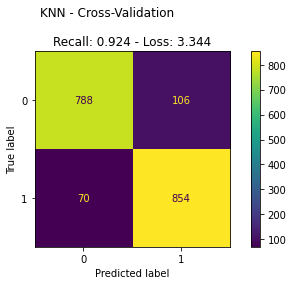

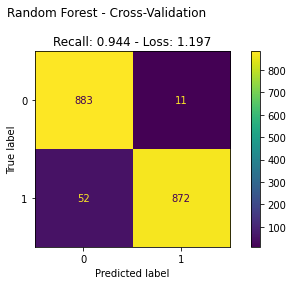

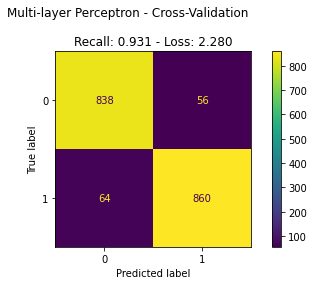

In [41]:
# Running KNN
result = evaluate_model(knn_kfold, X_test, y_test)
plot_confusion_matrix_fig('KNN - Cross-Validation', result)

# Running Random Forest
result = evaluate_model(random_forest_kfold, X_test, y_test)
plot_confusion_matrix_fig('Random Forest - Cross-Validation', result)

# Running MLP
result = evaluate_model(mlp_kfold, X_test, y_test)
plot_confusion_matrix_fig('Multi-layer Perceptron - Cross-Validation', result)

When the test dataset is used to evaluate the models, we observe a slight difference on the metrics but no difference on the overall result. Is important to note that for the models this is an unseen dataset. Here, the Random Forest continues with a low number of mis-classified examples and recall of 0.94, the highest between the models.

## Conclusion
In this experiment we used three machine learning models to classify licit and illicit transaction on bitcoin. We balanced and normalized the dataset before train and evaluate the models. To evaluate, we used a reserved 20% from the dataset for tests and the remaining examples were used to train.

We performed simple training and test with the models and the results, as shown in a confusion matrix with recall and loss metrics. The Random Forest model with 150 estimators was the better and got a recall of 0.947.

We ran a k-fold cross-validation to see the model’s ability to learn with a small portion of data. To show the results, we plotted ROC curves and the confusion matrixes for the models. This evaluation shows that all models had an excellent performance on small amount of data, and the Random Forest got the best results with a recall of 0.947.

The results show us that the Random Forest could be a candidate to classify illicit transaction on the bitcoin network.